<a href="https://colab.research.google.com/github/TheSpaceMan915/artificial-intelligence/blob/main/Sign_Language_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from joblib import dump, load
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold, cross_val_score, \
LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, \
HistGradientBoostingClassifier, RandomForestClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.saving import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, \
Dropout, Conv2D, MaxPooling2D, Input, ReLU, Softmax, Flatten, \
RandomFlip, RandomRotation, RandomZoom

# **Image Functions**

In [ ]:
def show_dataset_images(dataset_images):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset_images[i], cmap=plt.cm.binary)
    plt.tight_layout()

In [ ]:
def normalize_img(arr_img):
  arr_img = arr_img.astype("float32")
  arr_img /= 255
  return arr_img

In [ ]:
def reshape_img(arr_img):
  arr_img = arr_img.reshape(-1, 28, 28, 1)
  return arr_img

# **Model Functions**

In [ ]:
# creating an optimizer (SGD) with Time-Based Learning Rate Schedule
def create_optimizer(n_epochs):
  learning_rate = 0.1
  decay_rate = learning_rate / n_epochs
  momentum = 0.8
  
  sgd = SGD(learning_rate, momentum, weight_decay=decay_rate)
  return sgd

In [ ]:
def create_model(n_epochs, input_layer_shape=(28, 28, 1), n_classes=24):
  inputs = Input(input_layer_shape)
  x = Conv2D(16, (3,3), strides=1, padding = "same")(inputs)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPooling2D((2,2), strides = 2, padding = "same")(x)

  x = Conv2D(32, (3,3), strides=1, padding = "same")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPooling2D((2,2), strides = 2, padding = "same")(x)

  x = Conv2D(64, (3,3), strides=1, padding = "same")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPooling2D((2,2), strides = 2, padding = "same")(x)
  x = Flatten()(x)

  x = Dense(64, kernel_initializer="he_uniform")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.2)(x)

  x = Dense(32, kernel_initializer="he_uniform")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.2)(x)

  x = Dense(n_classes)(x)
  outputs = Softmax()(x)
  
  model = Model(inputs, outputs)
  # sgd = create_optimizer(n_epochs)
  # model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
def create_model_with_data_augmentation(n_epochs, input_layer_shape=(28, 28, 1), n_classes=24):
  inputs = Input(input_layer_shape)
  # data_augmentation = Sequential([
  #     RandomFlip("horizontal_and_vertical"),
  #     RandomRotation(0.2),
  #     RandomZoom(0.1)
  #     ])
  
  # x = data_augmentation(inputs)
  x = Conv2D(16, (3,3), strides=1, padding = "same")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPooling2D((2,2), strides = 2, padding = "same")(x)

  x = Conv2D(32, (3,3), strides=1, padding = "same")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPooling2D((2,2), strides = 2, padding = "same")(x)

  x = Conv2D(64, (3,3), strides=1, padding = "same")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPooling2D((2,2), strides = 2, padding = "same")(x)
  x = Flatten()(x)

  x = Dense(64, kernel_initializer="he_uniform")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.2)(x)

  x = Dense(32, kernel_initializer="he_uniform")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.2)(x)

  x = Dense(n_classes)(x)
  outputs = Softmax()(x)
  
  model = Model(inputs, outputs)
  sgd = create_optimizer(n_epochs)
  model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
def test_ml_model_accuracy(model, train_dataset, test_dataset, train_labels, test_labels):
  train_accuracy = model.score(train_dataset, train_labels)
  test_accuracy = model.score(test_dataset, test_labels)
  print(f"train_accuracy: {train_accuracy:.3f}")  
  print(f"test_accuracy: {test_accuracy:.3f}")

In [ ]:
def evaluate_model(model, dataset, labels, cross_validator):
  # evaluating the model
  arr_scores = cross_val_score(model, dataset,
                                labels, scoring="accuracy",
                                cv=cross_validator, n_jobs=-1,
                               error_score="raise")
  
  return arr_scores.mean(), arr_scores.min(), arr_scores.max()

In [ ]:
# evaluating the model using a test condition that represents an "ideal"
# or as-best-as-we-can-achieve estimate of model performance
def perform_leave_one_out_cross_validation(model, dataset, labels):
  ideal_score, _, _ = evaluate_model(model, dataset, labels, LeaveOneOut())
  print("ideal_score: %.3f" % ideal_score)
  return ideal_score

In [ ]:
def cross_validate_model(model, dataset, labels, folds):
  list_means, list_mins, list_maxs = list(), list(), list()
  
  for k in folds:
    cross_validator = KFold(n_splits=k, shuffle=True, random_state=1)
    mean_score, min_score, max_score = evaluate_model(model, dataset, labels, cross_validator)
    print("> folds=%d, mean_score=%.3f (min_score=%.3f, max_score=%.3f)" % k, mean_score, min_score, max_score)

    list_means.append(mean_score)
    list_mins.append(min_score)
    list_maxs.append(max_score)

  return list_means, list_mins, list_maxs

# **Plotting Functions**

In [ ]:
def plot_model_history(model_history, title):
    fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(14, 5))
    plt.rcParams.update({"font.size": 14, "font.family": "serif"})

    axes1.plot(model_history.history["accuracy"], label="accuracy")
    axes1.plot(model_history.history["val_accuracy"], label="val_accuracy")
    axes1.set(title="Accuracy of the model")
    axes1.set(xlabel="Epoch")
    axes1.set(ylabel="Accuracy")
    axes1.legend(loc=4)

    axes2.plot(model_history.history["loss"], label="loss")
    axes2.plot(model_history.history["val_loss"], label="val_loss")
    axes2.set(title="Losses of the model")
    axes2.set(xlabel="Epoch")
    axes2.set(ylabel="Loss")
    axes2.legend(loc=1)

    fig.tight_layout()
    plt.savefig(title)

In [ ]:
def plot_cross_validation_results(folds, ideal_score, list_means,list_mins, list_maxs, title):
  plt.errorbar(folds, list_means, yerr=[list_mins, list_maxs], fmt="o")
  plt.plot(folds, [ideal_score for _ in range(len(folds))], color="coral")
  
  plt.rcParams.update({"font.size": 14, "font.family": "serif"})
  plt.title("Cross validation results")
  plt.savefig(title)

# **MobileNetV2 Functions**

In [ ]:
# def create_expansion_block(x,t,filters,block_id):
#     prefix = "block_{}_".format(block_id)
#     total_filters = t*filters
#     # print(total_filters)
#     x = Conv2D(total_filters,1,padding="same",use_bias=False, name = prefix +"expand")(x)
#     x = BatchNormalization(name=prefix +"expand_bn")(x)
#     x = ReLU(6,name = prefix +"expand_relu")(x)
#     return x

# def create_depthwise_block(x,stride,block_id):
#     prefix = "block_{}_".format(block_id)
#     x = DepthwiseConv2D(3,strides=(stride,stride),padding ="same", use_bias = False, name = prefix + "depthwise_conv")(x)
#     x = BatchNormalization(name=prefix +"dw_bn")(x)
#     x = ReLU(6,name=prefix +"dw_relu")(x)
#     return x

# def create_projection_block(x,out_channels,block_id):
#     prefix = "block_{}_".format(block_id)
#     x = Conv2D(filters = out_channels,kernel_size = 1,padding="same",use_bias=False,name= prefix + "compress")(x)
#     x = BatchNormalization(name=prefix +"compress_bn")(x)
#     return x

In [ ]:
# def create_bottleneck(x,t,filters, out_channels,stride,block_id):
#     y = create_expansion_block(x,t,filters,block_id)
#     y = create_depthwise_block(y,stride,block_id)
#     y = create_projection_block(y, out_channels,block_id)
#     if y.shape[-1]==x.shape[-1]:
#         y = add([x,y])
#     return y

In [ ]:
# # initial shape: (28,28,1) 
# # mobilenetv2 shape: (224,224,3)
# def create_mobilenetv2(input_image_shape = (28,28,1), n_classes=25):
#   input = Input(input_image_shape)
#   x = Conv2D(32,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(input)
#   x = BatchNormalization(name='conv1_bn')(x)
#   x = ReLU(6, name = 'conv1_relu')(x)

#   # 17 bottleneck layers
#   x = create_depthwise_block(x,stride=1,block_id=1)
#   x = create_projection_block(x, out_channels=16,block_id=1)

#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)

#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)

#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)

#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)

#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)

#   x = create_bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 320, stride = 1,block_id = 17)

#   # 1*1 convolution
#   x = Conv2D(filters = 1280,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
#   x = BatchNormalization(name='last_bn')(x)
#   x = ReLU(6,name='last_relu')(x)

#   # AveragePooling 7*7
#   x = GlobalAveragePooling2D(name='global_average_pool')(x)

#   output = Dense(n_classes,activation='softmax')(x)
#   model = Model(input, output)

#   model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#   return model

In [ ]:
# create_mobilenetv2()
# was checking the number of filters in each convolution layer:

# **Loading Data**

In [ ]:
# don't forget to load kaggle.json to the content folder before
!pip install kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist

 67% 42.0M/62.6M [00:00<00:00, 142MB/s]
100% 62.6M/62.6M [00:00<00:00, 152MB/s]


In [ ]:
!mkdir datasets
!mv /content/sign-language-mnist.zip  /content/datasets
!unzip -q /content/datasets/sign-language-mnist.zip -d /content/datasets
!rm -rf /content/datasets/sign-language-mnist.zip

mkdir: cannot create directory ‘datasets’: File exists


In [ ]:
path_train_dataset = Path("/content/datasets/sign_mnist_train.csv")
path_test_dataset = Path("/content/datasets/sign_mnist_test.csv")
train_df = pd.read_csv(path_train_dataset)
test_df = pd.read_csv(path_test_dataset)

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


# **Transforming Data**

In [ ]:
train_labels = train_df["label"]
test_labels = test_df["label"]

# deleting labels from the dataframes
del train_df["label"]
del test_df["label"]

In [ ]:
train_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
test_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
# converting the labels to binary matrixes
label_binarizer = LabelBinarizer()
reshaped_train_labels = label_binarizer.fit_transform(train_labels)
reshaped_test_labels = label_binarizer.fit_transform(test_labels)

In [ ]:
train_dataset = train_df.values
test_dataset = test_df.values

In [ ]:
train_dataset = normalize_img(train_dataset)
test_dataset = normalize_img(test_dataset)

In [ ]:
print(train_dataset)

[[0.41960785 0.4627451  0.49803922 ... 0.8        0.79607844 0.7921569 ]
 [0.60784316 0.6156863  0.6117647  ... 0.40392157 0.5294118  0.58431375]
 [0.73333335 0.7372549  0.7372549  ... 0.7647059  0.7607843  0.7647059 ]
 ...
 [0.68235296 0.68235296 0.68235296 ... 0.7921569  0.78431374 0.78431374]
 [0.69411767 0.70980394 0.72156864 ... 0.2509804  0.34117648 0.3647059 ]
 [0.7019608  0.7058824  0.7058824  ... 0.8039216  0.81960785 0.84313726]]


In [ ]:
print("train_dataset shape:", train_dataset.shape)

train_dataset shape: (27455, 784)


In [ ]:
# reshaping the data from 2-D to 3-D
reshaped_train_dataset = reshape_img(train_dataset)
reshaped_test_dataset = reshape_img(test_dataset)

In [ ]:
print("reshaped_train_dataset shape:", reshaped_train_dataset.shape)

reshaped_train_dataset shape: (27455, 28, 28, 1)


In [ ]:
# this is an array of 3-D arrays. One 3-D array is one picture
print(reshaped_train_dataset)

[[[[0.41960785]
   [0.4627451 ]
   [0.49803922]
   ...
   [0.6666667 ]
   [0.6666667 ]
   [0.6627451 ]]

  [[0.43529412]
   [0.4745098 ]
   [0.5058824 ]
   ...
   [0.67058825]
   [0.67058825]
   [0.6666667 ]]

  [[0.44313726]
   [0.48235294]
   [0.5137255 ]
   ...
   [0.67058825]
   [0.67058825]
   [0.67058825]]

  ...

  [[0.5568628 ]
   [0.5882353 ]
   [0.62352943]
   ...
   [0.7921569 ]
   [0.7882353 ]
   [0.78431374]]

  [[0.5568628 ]
   [0.5921569 ]
   [0.627451  ]
   ...
   [0.8       ]
   [0.79607844]
   [0.7921569 ]]

  [[0.5568628 ]
   [0.5921569 ]
   [0.627451  ]
   ...
   [0.8       ]
   [0.79607844]
   [0.7921569 ]]]


 [[[0.60784316]
   [0.6156863 ]
   [0.6117647 ]
   ...
   [0.5411765 ]
   [0.36078432]
   [0.42352942]]

  [[0.61960787]
   [0.62352943]
   [0.62352943]
   ...
   [0.5568628 ]
   [0.45490196]
   [0.56078434]]

  [[0.6313726 ]
   [0.6313726 ]
   [0.6313726 ]
   ...
   [0.5764706 ]
   [0.49019608]
   [0.54901963]]

  ...

  [[0.63529414]
   [0.62352943]
   [0.5

In [ ]:
print(reshaped_test_dataset)

[[[[0.58431375]
   [0.58431375]
   [0.5882353 ]
   ...
   [0.5882353 ]
   [0.5882353 ]
   [0.58431375]]

  [[0.5882353 ]
   [0.5882353 ]
   [0.5882353 ]
   ...
   [0.5921569 ]
   [0.5882353 ]
   [0.5921569 ]]

  [[0.5882353 ]
   [0.5921569 ]
   [0.5921569 ]
   ...
   [0.5921569 ]
   [0.5921569 ]
   [0.59607846]]

  ...

  [[0.27058825]
   [0.27058825]
   [0.3019608 ]
   ...
   [0.45490196]
   [0.44313726]
   [0.4627451 ]]

  [[0.2901961 ]
   [0.29411766]
   [0.29803923]
   ...
   [0.43137255]
   [0.45490196]
   [0.44313726]]

  [[0.29411766]
   [0.2901961 ]
   [0.2901961 ]
   ...
   [0.4392157 ]
   [0.47058824]
   [0.41960785]]]


 [[[0.49411765]
   [0.5019608 ]
   [0.5137255 ]
   ...
   [0.52156866]
   [0.5254902 ]
   [0.5176471 ]]

  [[0.5058824 ]
   [0.5176471 ]
   [0.5254902 ]
   ...
   [0.53333336]
   [0.53333336]
   [0.5254902 ]]

  [[0.52156866]
   [0.5294118 ]
   [0.5411765 ]
   ...
   [0.54901963]
   [0.54509807]
   [0.5411765 ]]

  ...

  [[0.6784314 ]
   [0.68235296]
   [0.6

In [ ]:
# concatenating the data arrays
dataset = np.concatenate((train_dataset, test_dataset))
print(dataset)

[[0.41960785 0.4627451  0.49803922 ... 0.8        0.79607844 0.7921569 ]
 [0.60784316 0.6156863  0.6117647  ... 0.40392157 0.5294118  0.58431375]
 [0.73333335 0.7372549  0.7372549  ... 0.7647059  0.7607843  0.7647059 ]
 ...
 [0.74509805 0.7490196  0.74509805 ... 0.827451   0.81960785 0.8156863 ]
 [0.7882353  0.8039216  0.8156863  ... 0.2627451  0.27450982 0.24705882]
 [0.6784314  0.68235296 0.6784314  ... 0.7647059  0.75686276 0.7529412 ]]


In [ ]:
print(dataset.shape)

(34627, 784)


In [ ]:
# concatenating the labels
labels = pd.concat([train_labels, test_labels], ignore_index=True)
labels.head(10)

0     3
1     6
2     2
3     2
4    13
5    16
6     8
7    22
8     3
9     3
Name: label, dtype: int64

In [ ]:
print(labels.shape)

(34627,)


# **Modelling with NN Models**

In [ ]:
N_EPOCHS = 30
BATCH_SIZE = 1024

In [ ]:
# model with a standard Adam optimizer
model_v1 = create_model(N_EPOCHS)
model_v1.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_10 (ReLU)             (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                    

In [ ]:
# the results without data augmentation
model_v1_history = model_v1.fit(reshaped_train_dataset, reshaped_train_labels,
                            epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                            validation_data=(reshaped_test_dataset, reshaped_test_labels),
                            verbose=1)

Epoch 1/30
27/27 [==============================] - 7s 43ms/step - loss: 2.5372 - accuracy: 0.3084 - val_loss: 3.2284 - val_accuracy: 0.0395
Epoch 2/30
27/27 [==============================] - 1s 24ms/step - loss: 1.6472 - accuracy: 0.7089 - val_loss: 3.2972 - val_accuracy: 0.0343
Epoch 3/30
27/27 [==============================] - 1s 27ms/step - loss: 1.1418 - accuracy: 0.8792 - val_loss: 3.4295 - val_accuracy: 0.0488
Epoch 4/30
27/27 [==============================] - 1s 24ms/step - loss: 0.7798 - accuracy: 0.9429 - val_loss: 3.6947 - val_accuracy: 0.0549
Epoch 5/30
27/27 [==============================] - 1s 24ms/step - loss: 0.5394 - accuracy: 0.9701 - val_loss: 3.9500 - val_accuracy: 0.0899
Epoch 6/30
27/27 [==============================] - 1s 24ms/step - loss: 0.3902 - accuracy: 0.9829 - val_loss: 4.1887 - val_accuracy: 0.0876
Epoch 7/30
27/27 [==============================] - 1s 24ms/step - loss: 0.2919 - accuracy: 0.9877 - val_loss: 4.2789 - val_accuracy: 0.0885
Epoch 8/30
27

In [ ]:
N_EPOCHS = 40
BATCH_SIZE = 1024

In [ ]:
# model with a modified SGD optimizer
model_v2 = create_model(N_EPOCHS)
model_v2.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_110 (Ba  (None, 28, 28, 16)       64        
 tchNormalization)                                               
                                                                 
 re_lu_110 (ReLU)            (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 14, 14, 32)        464

In [ ]:
# the results without data augmentation
model_v2_history = model_v2.fit(reshaped_train_dataset, reshaped_train_labels,
                            epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                            validation_data=(reshaped_test_dataset, reshaped_test_labels),
                            verbose=1)

Epoch 1/40
27/27 [==============================] - 4s 47ms/step - loss: 2.0640 - accuracy: 0.4695 - val_loss: 3.1512 - val_accuracy: 0.0357
Epoch 2/40
27/27 [==============================] - 1s 28ms/step - loss: 0.6146 - accuracy: 0.8754 - val_loss: 3.2024 - val_accuracy: 0.0633
Epoch 3/40
27/27 [==============================] - 1s 25ms/step - loss: 0.2588 - accuracy: 0.9540 - val_loss: 3.2622 - val_accuracy: 0.0605
Epoch 4/40
27/27 [==============================] - 1s 26ms/step - loss: 0.1570 - accuracy: 0.9733 - val_loss: 3.0582 - val_accuracy: 0.0968
Epoch 5/40
27/27 [==============================] - 1s 25ms/step - loss: 0.1083 - accuracy: 0.9830 - val_loss: 2.9288 - val_accuracy: 0.1129
Epoch 6/40
27/27 [==============================] - 1s 24ms/step - loss: 0.0882 - accuracy: 0.9854 - val_loss: 2.9046 - val_accuracy: 0.1124
Epoch 7/40
27/27 [==============================] - 1s 24ms/step - loss: 0.0758 - accuracy: 0.9880 - val_loss: 2.4954 - val_accuracy: 0.2471
Epoch 8/40
27

In [ ]:
model_v2.save("model_v2_95%.h5")

In [ ]:
N_EPOCHS = 30
BATCH_SIZE = 1024

In [ ]:
model_v3 = create_model_with_data_augmentation(N_EPOCHS)
model_v3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                       

In [ ]:
# fitting with data augmentation (with a RandomFlip layer)
model_v3_history = model_v3.fit(reshaped_train_dataset, reshaped_train_labels,
                            epochs=N_EPOCHS, batch_size=BATCH_SIZE,
                            validation_data=(reshaped_test_dataset, reshaped_test_labels),
                            verbose=1)

Epoch 1/30
27/27 [==============================] - 4s 48ms/step - loss: 3.0974 - accuracy: 0.1002 - val_loss: 3.2567 - val_accuracy: 0.0371
Epoch 2/30
27/27 [==============================] - 1s 33ms/step - loss: 2.6119 - accuracy: 0.2016 - val_loss: 3.6406 - val_accuracy: 0.0287
Epoch 3/30
27/27 [==============================] - 1s 27ms/step - loss: 2.2564 - accuracy: 0.2834 - val_loss: 4.2447 - val_accuracy: 0.0293
Epoch 4/30
27/27 [==============================] - 1s 26ms/step - loss: 1.8587 - accuracy: 0.3869 - val_loss: 4.3804 - val_accuracy: 0.0678
Epoch 5/30
27/27 [==============================] - 1s 26ms/step - loss: 1.6139 - accuracy: 0.4610 - val_loss: 3.8327 - val_accuracy: 0.0873
Epoch 6/30
27/27 [==============================] - 1s 25ms/step - loss: 1.4259 - accuracy: 0.5154 - val_loss: 4.6268 - val_accuracy: 0.0353
Epoch 7/30
27/27 [==============================] - 1s 25ms/step - loss: 1.2978 - accuracy: 0.5555 - val_loss: 2.9377 - val_accuracy: 0.2108
Epoch 8/30
27

In [ ]:
N_EPOCHS = 30
BATCH_SIZE = 1024

In [ ]:
model_v4 = create_model(N_EPOCHS)
model_v4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640  

In [ ]:
# creating an ImageDataGenerator with data augmentation (to prevent overfitting)
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.1,
                             width_shift_range=0.1, height_shift_range=0.1)

datagen.fit(reshaped_train_dataset)

In [ ]:
# fitting with the ImageDataGenerator
model_v4_history = model_v4.fit(datagen.flow(reshaped_train_dataset, reshaped_train_labels, batch_size=BATCH_SIZE),
                            epochs=N_EPOCHS,
                            validation_data=(reshaped_test_dataset, reshaped_test_labels),
                            verbose=1)

Epoch 1/30
27/27 [==============================] - 21s 371ms/step - loss: 2.4720 - accuracy: 0.3013 - val_loss: 3.1358 - val_accuracy: 0.1272
Epoch 2/30
27/27 [==============================] - 10s 373ms/step - loss: 1.3112 - accuracy: 0.6178 - val_loss: 2.8655 - val_accuracy: 0.1287
Epoch 3/30
27/27 [==============================] - 9s 332ms/step - loss: 0.7915 - accuracy: 0.7592 - val_loss: 2.8106 - val_accuracy: 0.1825
Epoch 4/30
27/27 [==============================] - 8s 307ms/step - loss: 0.5473 - accuracy: 0.8364 - val_loss: 2.7124 - val_accuracy: 0.1500
Epoch 5/30
27/27 [==============================] - 7s 277ms/step - loss: 0.4190 - accuracy: 0.8766 - val_loss: 2.6000 - val_accuracy: 0.2008
Epoch 6/30
27/27 [==============================] - 11s 431ms/step - loss: 0.3075 - accuracy: 0.9136 - val_loss: 2.4060 - val_accuracy: 0.2843
Epoch 7/30
27/27 [==============================] - 9s 346ms/step - loss: 0.2484 - accuracy: 0.9301 - val_loss: 1.9768 - val_accuracy: 0.3956
Epo

In [ ]:
model_v5 = create_model(N_EPOCHS)
model_v5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640  

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=2,
                                            factor=0.3, min_lr=0.00001,
                                            verbose=1)

In [ ]:
# fitting with the ImageDataGenerator, learning_rate_reduction and Adam optimizer
model_v5_history = model_v5.fit(datagen.flow(reshaped_train_dataset, reshaped_train_labels, batch_size=BATCH_SIZE),
                            epochs=30,
                            validation_data=(reshaped_test_dataset, reshaped_test_labels),
                            verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/30
27/27 [==============================] - 32s 426ms/step - loss: 2.7984 - accuracy: 0.1906 - val_loss: 3.2374 - val_accuracy: 0.0484 - lr: 0.0010
Epoch 2/30
27/27 [==============================] - 10s 383ms/step - loss: 2.1133 - accuracy: 0.4520 - val_loss: 3.3312 - val_accuracy: 0.0484 - lr: 0.0010
Epoch 3/30
27/27 [==============================] - 12s 437ms/step - loss: 1.6672 - accuracy: 0.6219 - val_loss: 3.4125 - val_accuracy: 0.0551 - lr: 0.0010
Epoch 4/30
27/27 [==============================] - 11s 410ms/step - loss: 1.3129 - accuracy: 0.7225 - val_loss: 3.4191 - val_accuracy: 0.0485 - lr: 0.0010
Epoch 5/30
27/27 [==============================] - ETA: 0s - loss: 1.0442 - accuracy: 0.7882
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
27/27 [==============================] - 10s 356ms/step - loss: 1.0442 - accuracy: 0.7882 - val_loss: 3.4707 - val_accuracy: 0.0485 - lr: 0.0010
Epoch 6/30
27/27 [==============================] - 11s 424ms

In [ ]:
model_v5.save("model_v5_99%.h5")

In [ ]:
model_v6 = create_model(N_EPOCHS)
model_v6.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_20 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_20 (ReLU)             (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        4640

In [ ]:
# fitting with the ImageDataGenerator, learning_rate_reduction and Adam optimizer
model_v6_history = model_v6.fit(datagen.flow(reshaped_train_dataset, reshaped_train_labels, batch_size=BATCH_SIZE),
                            epochs=30,
                            validation_data=(reshaped_test_dataset, reshaped_test_labels),
                            verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/30
27/27 [==============================] - 14s 314ms/step - loss: 2.8225 - accuracy: 0.1804 - val_loss: 3.1976 - val_accuracy: 0.0510 - lr: 0.0010
Epoch 2/30
27/27 [==============================] - 10s 369ms/step - loss: 2.1656 - accuracy: 0.4267 - val_loss: 3.2384 - val_accuracy: 0.0467 - lr: 0.0010
Epoch 3/30
27/27 [==============================] - 10s 388ms/step - loss: 1.7104 - accuracy: 0.5925 - val_loss: 3.2738 - val_accuracy: 0.0666 - lr: 0.0010
Epoch 4/30
27/27 [==============================] - 8s 312ms/step - loss: 1.3467 - accuracy: 0.7057 - val_loss: 3.2737 - val_accuracy: 0.0738 - lr: 0.0010
Epoch 5/30
27/27 [==============================] - 10s 371ms/step - loss: 1.0778 - accuracy: 0.7750 - val_loss: 3.2566 - val_accuracy: 0.1100 - lr: 0.0010
Epoch 6/30
27/27 [==============================] - 10s 369ms/step - loss: 0.8637 - accuracy: 0.8246 - val_loss: 3.1960 - val_accuracy: 0.1108 - lr: 0.0010
Epoch 7/30
27/27 [==============================] - 8s 314ms/step

# **Modelling with ML Models**

In [ ]:
path_dir = Path("/content/drive/MyDrive/Colab Notebooks/AI/Other files/Sign Language Project")
folds = range(2, 31)

In [ ]:
# predicting with AdaBoostClassifier
adaboost_classsifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                        n_estimators=100)

fitted_adaboost_classsifier = adaboost_classsifier.fit(train_dataset, train_labels)

In [ ]:
test_ml_model_accuracy(adaboost_classsifier, train_dataset, 
                       test_dataset, train_labels, 
                       test_labels)

train_accuracy: 1.000
test_accuracy: 0.434


In [ ]:
# saving the fitted_adaboost_classsifier
dump(fitted_adaboost_classsifier, path_dir.joinpath("fitted_adaboost_classsifier.joblib"))

['/content/drive/MyDrive/Colab Notebooks/AI/Other files/Sign Language Project/fitted_adaboost_classsifier.joblib']

In [ ]:
# loading the fitted_adaboost_classsifier
fitted_adaboost_classsifier = load(path_dir.joinpath("fitted_adaboost_classsifier.joblib"))

In [ ]:
# takes a massive amount of time on CPU (more than 3h 58m)
ideal_adaboost_score = perform_leave_one_out_cross_validation(fitted_adaboost_classsifier, dataset, labels)
print(ideal_adaboost_score)

In [ ]:
# evaluating AdaBoostClassifier using cross-validation
list_adaboost_means, list_adaboost_mins, list_adaboost_maxs = cross_validate_model(fitted_adaboost_classsifier, dataset,
                                                                                   labels, folds)

In [ ]:
# predicting with HistGradientBoostingClassifier
hist_classifier = HistGradientBoostingClassifier(max_iter=100)
fitted_hist_classifier = hist_classifier.fit(train_dataset, train_labels)

In [ ]:
test_ml_model_accuracy(fitted_hist_classifier, train_dataset, 
                       test_dataset, train_labels, 
                       test_labels)

train_accuracy: 1.000
test_accuracy: 0.798


In [ ]:
# saving the fitted_hist_classifier
dump(fitted_hist_classifier, path_dir.joinpath("fitted_hist_classifier.joblib"))

['/content/drive/MyDrive/Colab Notebooks/AI/Other files/Sign Language Project/fitted_hist_classifier.joblib']

In [ ]:
# loading the fitted_hist_classifier
fitted_hist_classifier = load(path_dir.joinpath("fitted_hist_classifier.joblib"))

In [ ]:
# predicting with RandomForestClassifier
randforest_classifier = RandomForestClassifier(n_estimators=100)
randforest_classifier.fit(train_dataset, train_labels)

In [ ]:
test_ml_model_accuracy(randforest_classifier, train_dataset, 
                       test_dataset, train_labels, 
                       test_labels)

train_accuracy: 1.000
test_accuracy: 0.812


In [ ]:
# saving the randforest_classifier
dump(randforest_classifier, path_dir.joinpath("randforest_classifier.joblib"))

['/content/drive/MyDrive/Colab Notebooks/AI/Other files/Sign Language Project/randforest_classifier.joblib']

In [ ]:
# loading the randforest_classifier
randforest_classifier = load(path_dir.joinpath("randforest_classifier.joblib"))

In [ ]:
ideal_randforest_score = perform_leave_one_out_cross_validation(randforest_classifier, dataset, labels)

In [ ]:
# evaluating RandomForestClassifier using cross-validation
list_randforest_means, list_randforest_mins, list_randforest_maxs = cross_validate_model(randforest_classifier, dataset,
                                                                                         labels, folds)

# **Visualisation**

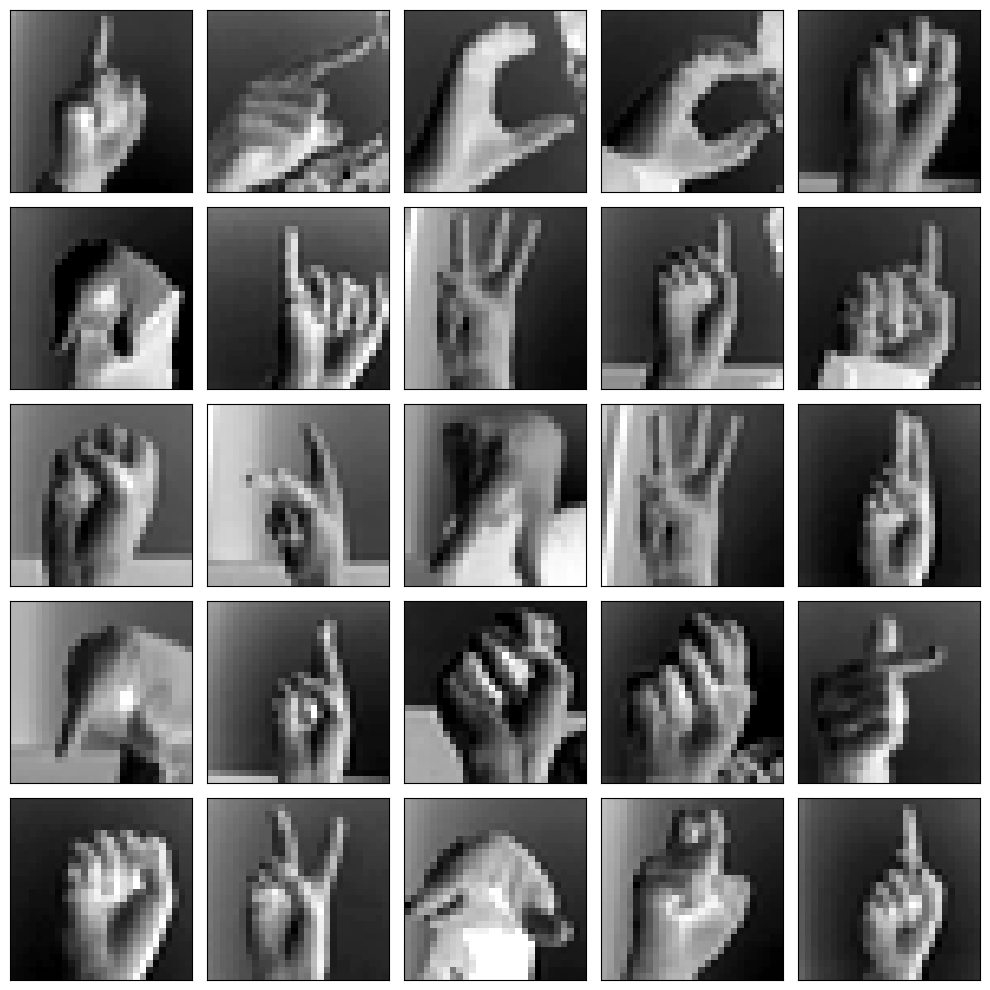

In [ ]:
# ought to save each picture (3-D array) using tensorflow.keras.utils.save_img
show_dataset_images(reshaped_train_dataset)

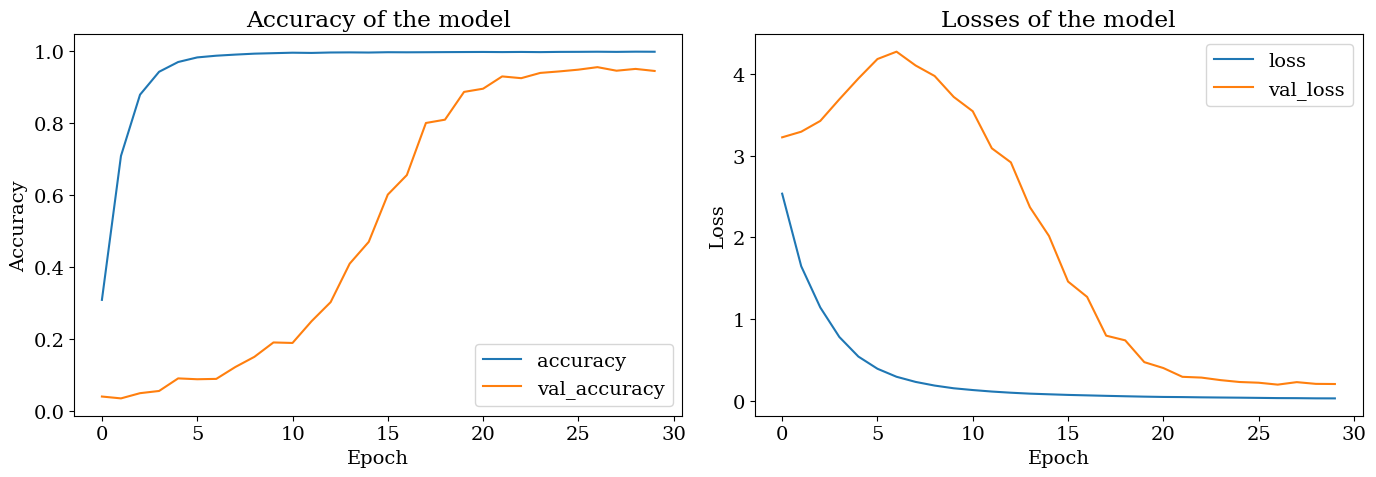

In [ ]:
plot_model_history(model_v1_history, "model_v1_history")

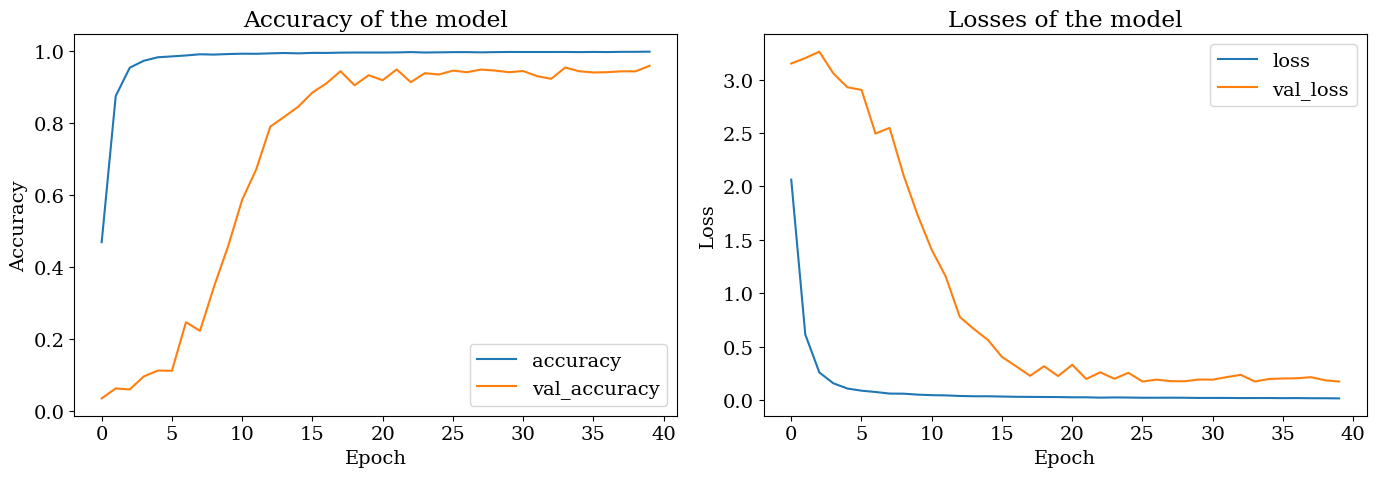

In [ ]:
plot_model_history(model_v2_history, "model_v2_history")

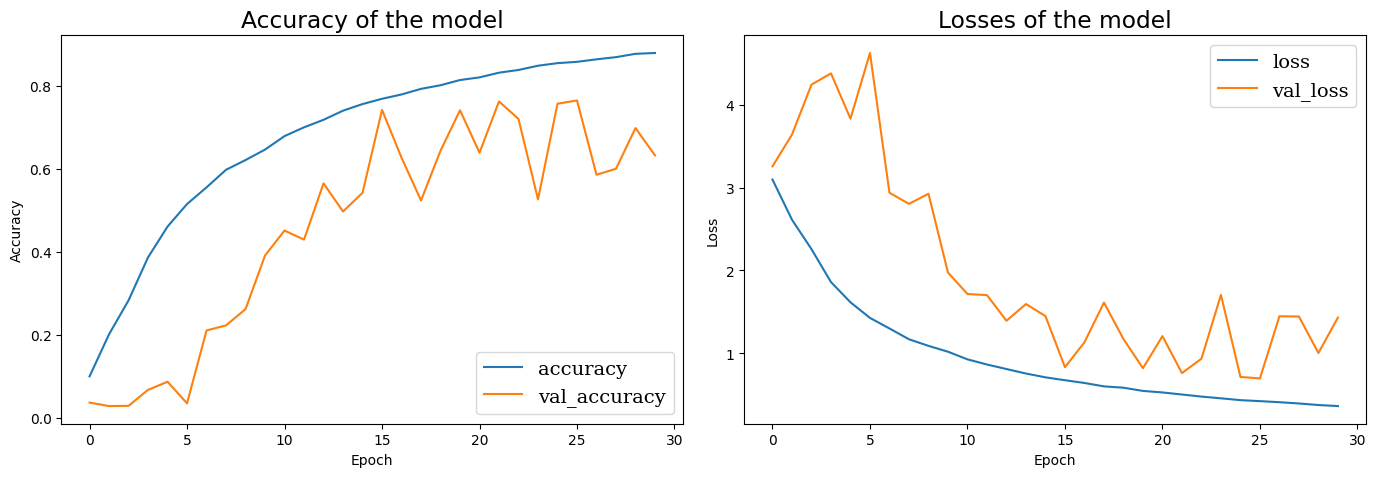

In [ ]:
plot_model_history(model_v3_history, "model_v3_history")

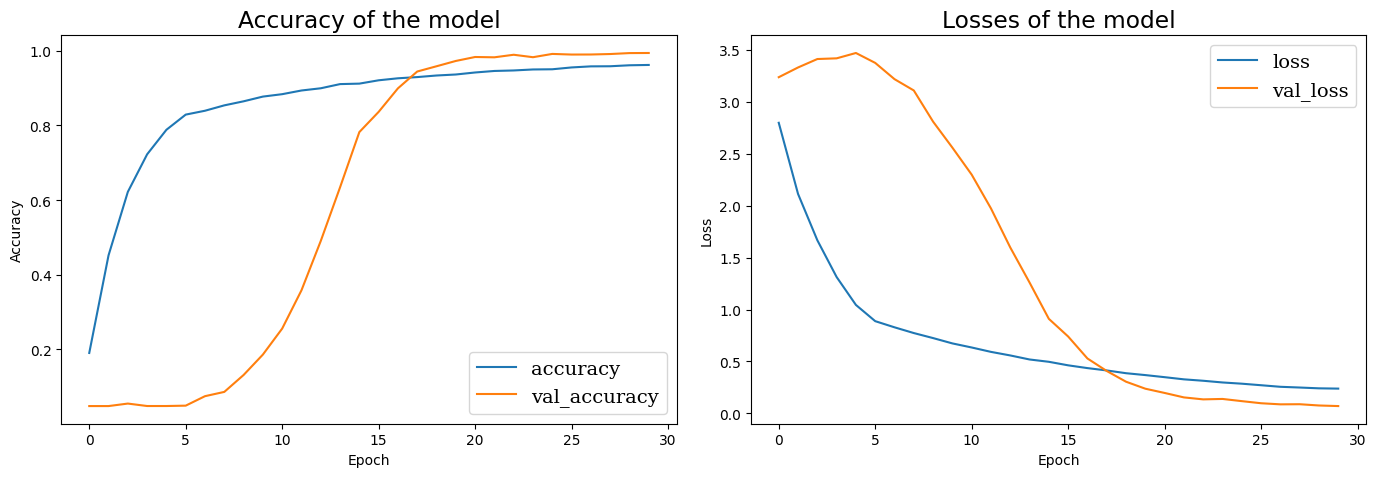

In [ ]:
plot_model_history(model_v5_history, "model_v5_history")

In [ ]:
plot_cross_validation_results(folds, ideal_adaboost_score, list_adaboost_means,
                              list_adaboost_mins, list_adaboost_maxs,
                              "adaboost cross validation")

In [ ]:
plot_cross_validation_results(folds, ideal_randforest_score, list_randforest_means,
                              list_randforest_mins, list_randforest_maxs,
                              "randforest cross validation")